# Notebook for the model training

#### Classification between 'Normal' and 'Crack' images

## 1. imports

In [1]:
import os
import glob
import sys
from pathlib import Path

from PIL import Image

# plots and images
import matplotlib.pyplot as plt
import numpy as np

# Pytorch
import torch

In [2]:
# If we want to use google drive
_USE_G_DRIVE = False

In [3]:
# Mount google drive
base_path = "../"
if _USE_G_DRIVE:
  from google.colab import drive

  drive.mount("/content/drive/")
  base_path = Path('/content/drive/My Drive/Bridges-Crack-Detection/')
  sys.path.append(str(base_path))

# import our src package
sys.path.append(str("../"))
sys.path.append(str("../src/"))

#### Import model and utility functions

In [4]:
from src.utils.utils import init_random, get_device
from src.utils.model import get_model
from src.utils.dataloader import load_data
from src.utils.trainer import train_model

## 2. Variables definition

### Definizione Variabili Generiche### General Variables

In [5]:
# Training Data folder containing 2 subfolders: Positive and Negative
DS_PATH = os.path.join(base_path, "Dataset/Train/")
#------------------------------------------------
# output model path
MODEL_SAVE_PATH= os.path.join(base_path, "SavedWeights/trained_model.pt")
#------------------------------------------------
seed = 0
validation_size = 0.3
epochs = 5
lr = 0.001
wd = 5e-3
batch_size = 512
n_classes = 2

print("----- Paths -----")
print("Path Dataset To Classify:", str(DS_PATH))
print("Path Model Params:", str(MODEL_SAVE_PATH))

----- Paths -----
Path Dataset To Classify: ../Dataset/Train/
Path Model Params: ../SavedWeights/trained_model.pt


## 3. Data Preparation

### Init

In [6]:
# set deterministic to true to have deterministic results, set it to false to have faster inference
deterministic_behaviour = True
init_random(deterministic_behaviour, seed)
device = get_device()

### Load Training and Validation set

In [7]:
# Load data
train_dl, valid_dl = load_data(data_path, validation_size=validation_size, seed=seed,
                     batch_size=batch_size)

# Print train and valid size
print("Elements Training set: " + str(len(train_dl)))
print("Elements Validation set: " + str(len(valid_dl)))

Loaded 20000 images with class_id=0
Loaded 20000 images with class_id=1
Elements Training set: 55
Elements Validation set: 24


## 4. Visualizzazione dei 2 Subset

In [15]:
# Numero di immagini da mostrare
plots = 4
# Dimensioni delle immagini
# Altezza
plot_height = 20
# Larghezza
plot_width = 20
# -----

def show_data(folder_path, title="", n_plots=4, n_plot_height=20, n_plot_width=20):
  fig,a =  plt.subplots(1, n_plots)
  fig.set_figheight(n_plot_height)
  fig.set_figwidth(n_plot_width)
  data_to_show = glob.glob(os.path.join(folder_path, "*"))
  # INDEX PARTENZA GENERATO A CASO E POI MI PRENDO plots IMMAGINI DA QUEL PUNTO DA MANDARE A SCHERMO
  starting_index = np.random.randint(len(data_to_show) - (plots + 1))
  # Carico le immagini
  for i in range(plots):
      a[i].imshow(Image.open(data_to_show[starting_index + i]))
      a[i].set_title(title + " " + str(i))

### Immagini di muri Normali (Senza crepe/spalling)

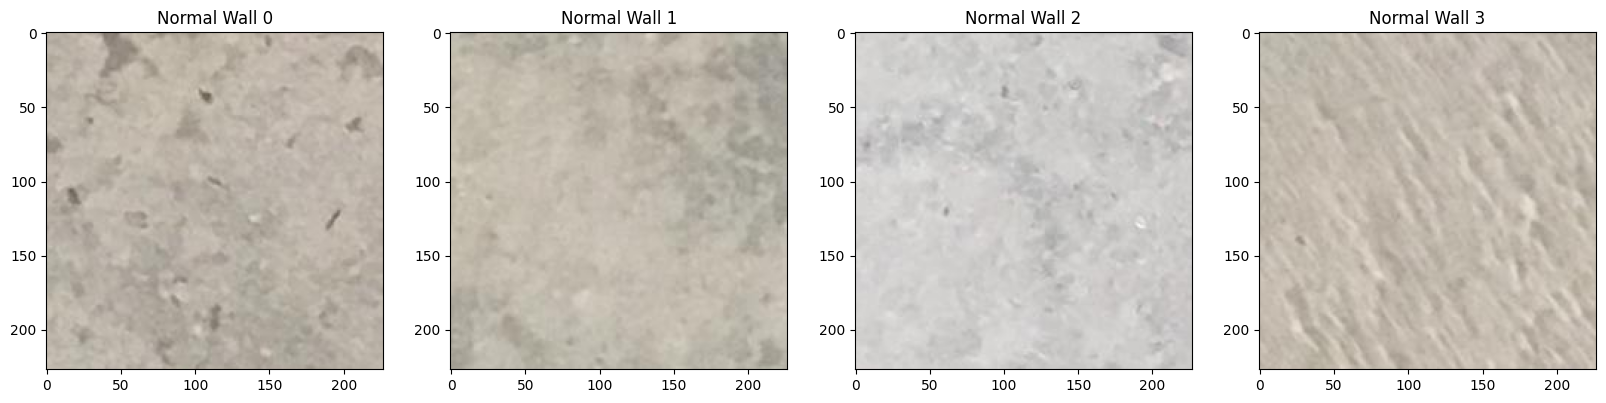

In [16]:
show_data(os.path.join(data_path, "Negative"), title = "Normal Wall", n_plots = plots, n_plot_height = plot_height, n_plot_width = plot_width)

### Immagini di Muri con delle crepe

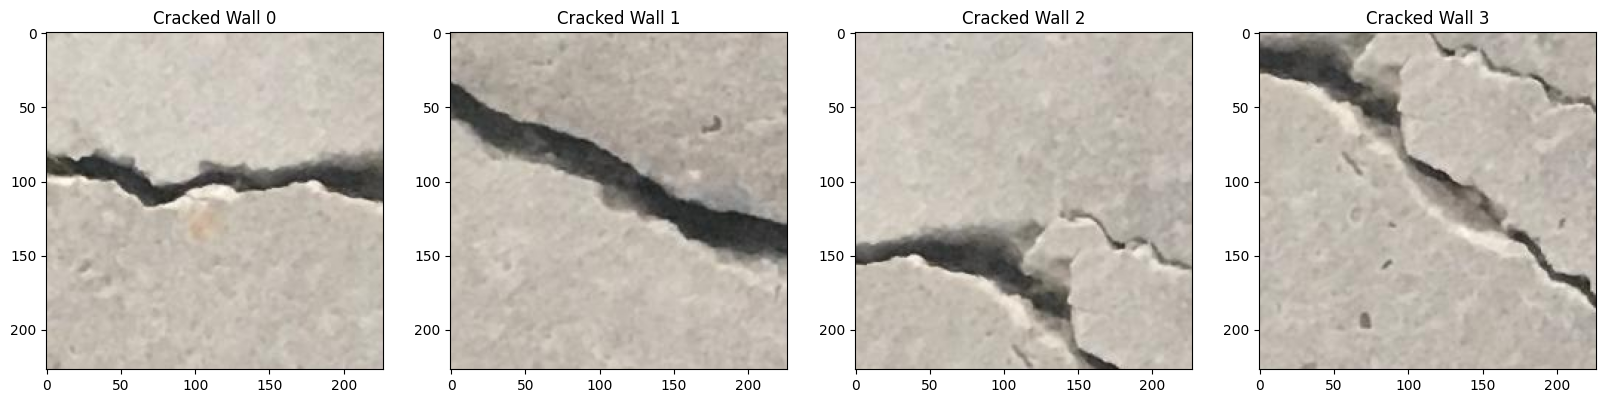

In [17]:
show_data(os.path.join(data_path, "Positive"), title = "Cracked Wall", n_plots = plots, n_plot_height = plot_height, n_plot_width = plot_width)

## 6. Training della Rete

### Metodo usato per il Fit della rete

In [ ]:
# Per semplicità di scrittura e lettura importo le funzioni di step
from src.utils.trainer import train_model
from JDModel import training_step as training_step
from JDModel import validation_step as validation_step

def fit(epochs, model, train_dl, valid_dl, opt, loss_fn, device=None):
    # Get the model, only train the classifier
    model = get_model(device=device, fine_tune=True, n_classes=config["n_classes"])

    # Setup optimizer, scheduler and scaler
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["wd"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=0, last_epoch=-1)
    scaler = torch.cuda.amp.GradScaler(enabled=device == "cuda")

    # Load data
    data = load_data(config["data_path"], validation_size=config["validation_size"], seed=config["seed"],
                     batch_size=config["batch_size"])

    # Train the model
    best_model, best_model_accuracy = train_model(model, optimizer, scheduler, scaler, data,
                                                  device, epochs=config["epochs"])

    # Save the trained model and print its validation accuracy
    print(f"The best model has a validation accuracy of: {best_model_accuracy}")
    return best_model, best_model_accuracy

### Caricamento pesi della rete pre-allenata

In [ ]:
%%time
model, opt = JDModel.get_model(model_name=network_model_name, lr=LR, wd=WD, feature_extracting=feature_extract, n_classes=OC)

print("Model backbone 'params': ", len(model.backbone.parameters()))
print("Dispositivo per training:", str(JDModel.get_device()))

### Training effettivo della rete (Fine-tuning)

In [ ]:
%%time
model, train_loss, train_accuracy, valid_loss, valid_accuracy = fit(TE, model, train_dl, valid_dl, opt, loss_fn)

## 7. Plot Risultati del Training

### Plot Training Loss

In [ ]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.title('Loss vs. No. of Epochs');
plt.grid()

### Plot Training Accuracy

In [ ]:
# NORMALIZZO DA 0 A 1 E TOLGO I NUMERI DOPO 2 POSIZIONI NELLA VIRGOLA
train_accuracy_normalized = np.array(np.round(train_accuracy, 2)) / 100
valid_accuracy_normalized = np.array(np.round(valid_accuracy, 2)) / 100

# FIGURA
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_accuracy_normalized, '-bx')
plt.plot(valid_accuracy_normalized, '-rx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Accuracy')
plt.ylim(-0.15, 1.15)
plt.legend(['Training Set', 'Validation Set'])
plt.title('Accuracy vs. No. of Epochs');
plt.grid()

# NUMERINI SULLA GRIGLIA
#for x,y in zip(trains_accuracy_normalized, range(0, len(trains_accuracy_normalized))):
#    plt.annotate(str(x),xy=(y-0.05 ,x + 0.02))

## 8. Salvataggio del Modello

### Salvataggio del modello

In [ ]:
# Salvataggio
torch.save(model.state_dict(), MODEL_SAVE_PATH)
# Mi scollego dal drive
if _COLAB_IN_USE:
  drive.flush_and_unmount()